In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import gc
from tqdm import tqdm, tqdm_notebook
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error, f1_score, roc_auc_score
from mlxtend.regressor import StackingCVRegressor
import datetime
import time
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
%matplotlib inline

In [13]:
# 使用鱼佬0.51baseline的方法对于用户评论和新闻数据进行补充后的数据集
path  = '../mid_data/'

data=pd.read_csv(os.path.join(path,'fix_NaN_data.csv'))

In [14]:
data.tail()

Unnamed: 0  index  adcode bodyType    id             model  regMonth  \
36955       36955  23827  330000      SUV  4877  936168bd4850913d         4   
36956       36956  23855  420000      SUV  4878  936168bd4850913d         4   
36957       36957  23883  430000      SUV  4879  936168bd4850913d         4   
36958       36958  23687  450000      SUV  4872  936168bd4850913d         4   
36959       36959  36959  230000      SUV  5368  a9a43d1a7ecbe75d         4   

       regYear    popularity  carCommentVolum  newsReplyVolum        label  \
36955     2018  14823.059093       167.981104     8115.393341  1949.160201   
36956     2018   2180.582640        42.098003     3094.885884   205.774330   
36957     2018   1198.956494      3079.604557    23116.807009    82.249256   
36958     2018   1339.041537       316.798834        0.000000   361.643376   
36959     2018    490.597433       299.273227      406.966754   118.729064   

       province_rank  date_block_num  class_id  
36955              1              28       879  
36956              3              28       939  
36957              3              28       999  
36958              4              28       579  
36959              5              28      1320

In [54]:
data.head()

Unnamed: 0  index  adcode   bodyType  id             model  regMonth  \
0           0      0  310000        SUV   0  3c974920a76ac9c1         1   
1           1  30268  110000  Hatchback   0  3e21824be728cbec         1   
2           2  17500  450000        SUV   0  bb9fbec9a2833839         1   
3           3   6048  210000      Sedan   0  7cf283430b3b5e38         1   
4           4  30296  510000  Hatchback   0  3e21824be728cbec         1   

   regYear  popularity  carCommentVolum  newsReplyVolum  label  province_rank  \
0     2016      1479.0             11.0           106.0  292.0              3   
1     2016      1618.0             79.0          1763.0  315.0              2   
2     2016       971.0              4.0           920.0  131.0              4   
3     2016      1526.0            270.0          3705.0  589.0              4   
4     2016      3076.0             79.0          1763.0  825.0              2   

   date_block_num  class_id  
0               1         0  
1               1         1  
2               1         2  
3               1         3  
4               1         4

In [51]:
data.to_csv('../mid_data/data_new_class_id.csv',index=False)

# 按豆腐所说将销量稳定的车型选择出来

In [17]:
data=pd.read_csv('../mid_data/data_new_class_id.csv')

In [18]:
label_std=[]
total_nums=[]
class_ids=data.class_id.unique()
for i in class_ids:
    label_std.append(data.loc[data.class_id==i,'label'].std())
    total_nums.append(len(data.loc[data.class_id==i,'label']))

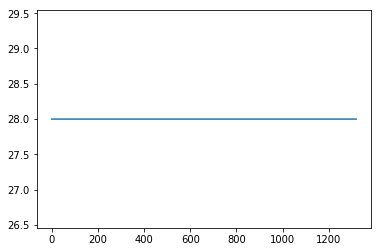

In [19]:
plt.plot(range(len(total_nums)),total_nums)

In [20]:
min(total_nums)

28

In [21]:
print(label_std)

[364.90588545817235, 229.99074530403428, 1150.7064045168852, 324.87657878455747, 246.2363793963887, 260.75996248613257, 99.1560878093086, 368.18844159612223, 135.12464757179654, 551.1837672478737, 174.6041087290871, 228.39469725748438, 306.0080380065192, 193.44353456705528, 693.6050786171677, 281.9927202618628, 367.18492471923736, 153.21346371778836, 326.602986090869, 1313.58764266505, 234.72969128730253, 421.28716146628415, 1197.7762608676958, 251.08067513748986, 189.13043487249772, 460.4021299526196, 379.61577700921964, 1052.4390547659214, 122.09730392021935, 101.73610269068409, 1070.4116818982309, 652.855531758761, 907.0808734548367, 421.4687586433033, 1405.9295274994079, 150.91269156479632, 677.9270558580876, 178.3493132932842, 618.0894204884424, 124.07521305685206, 840.5734365281066, 931.6158844991983, 156.74328328864823, 163.22823366697867, 182.31520727998483, 3027.986633933423, 1032.3285784868385, 507.1566926617765, 73.74495661984253, 687.8815035633886, 760.3598254353592, 389.07

In [22]:
min(label_std)

27.38963442567652

In [23]:
small_std=[]
for i in range(len(label_std)):
    if label_std[i]<100:
        small_std.append(i)
print(small_std)
print(len(small_std))

[6, 48, 52, 74, 80, 113, 207, 233, 249, 283, 348, 362, 366, 379, 383, 414, 444, 479, 589, 603, 606, 626, 641, 670, 722, 915, 921, 935, 968, 1217, 1254, 1266]
32


In [24]:
data.loc[data.class_id==879]

Unnamed: 0  index  adcode bodyType    id             model  regMonth  \
879           879  27300  140000      SUV     0  5b1c11c3efed5312         1   
1665         1665  27301  140000      SUV     0  5b1c11c3efed5312         2   
3687         3687  27302  140000      SUV     0  5b1c11c3efed5312         3   
4840         4840  27303  140000      SUV     0  5b1c11c3efed5312         4   
6277         6277  27304  140000      SUV     0  5b1c11c3efed5312         5   
7518         7518  27305  140000      SUV     0  5b1c11c3efed5312         6   
7975         7975  27306  140000      SUV     0  5b1c11c3efed5312         7   
9387         9387  27307  140000      SUV     0  5b1c11c3efed5312         8   
11207       11207  27308  140000      SUV     0  5b1c11c3efed5312         9   
12568       12568  27309  140000      SUV     0  5b1c11c3efed5312        10   
13509       13509  27310  140000      SUV     0  5b1c11c3efed5312        11   
15633       15633  27311  140000      SUV     0  5b1c11c3efed5312        12   
16664       16664  27312  140000      SUV     0  5b1c11c3efed5312         1   
17825       17825  27313  140000      SUV     0  5b1c11c3efed5312         2   
18531       18531  27314  140000      SUV     0  5b1c11c3efed5312         3   
20744       20744  27315  140000      SUV     0  5b1c11c3efed5312         4   
22080       22080  27316  140000      SUV     0  5b1c11c3efed5312         5   
22766       22766  27317  140000      SUV     0  5b1c11c3efed5312         6   
24222       24222  27318  140000      SUV     0  5b1c11c3efed5312         7   
25184       25184  27319  140000      SUV     0  5b1c11c3efed5312         8   
26608       26608  27320  140000      SUV     0  5b1c11c3efed5312         9   
28974       28974  27321  140000      SUV     0  5b1c11c3efed5312        10   
29129       29129  27322  140000      SUV     0  5b1c11c3efed5312        11   
30790       30790  27323  140000      SUV     0  5b1c11c3efed5312        12   
32622       32622  27324  140000      SUV   976  5b1c11c3efed5312         1   
33798       33798  27325  140000      SUV  2318  5b1c11c3efed5312         2   
35394       35394  27326  140000      SUV  3660  5b1c11c3efed5312         3   
36421       36421  27327  140000      SUV  5002  5b1c11c3efed5312         4   

       regYear    popularity  carCommentVolum  newsReplyVolum        label  \
879       2016   1500.000000        35.000000    2.830000e+02   310.000000   
1665      2016   2080.000000        20.000000    4.000000e+01   114.000000   
3687      2016   1515.000000        41.000000    1.680000e+02   172.000000   
4840      2016   1213.000000        24.000000    7.420000e+02   156.000000   
6277      2016   1203.000000        37.000000    7.800000e+01   184.000000   
7518      2016   1101.000000        61.000000    2.700000e+01   119.000000   
7975      2016    991.000000        89.000000    7.660000e+02   112.000000   
9387      2016    871.000000        42.000000    4.000000e+01   180.000000   
11207     2016    896.000000        61.000000    2.288000e+03   176.000000   
12568     2016    927.000000        62.000000    1.707000e+03   226.000000   
13509     2016    911.000000        47.000000    1.174000e+03   231.000000   
15633     2016    925.000000        38.000000    2.300000e+01   426.000000   
16664     2017    778.000000        36.000000    2.600000e+01   153.000000   
17825     2017   1120.000000        30.000000    2.800000e+01    81.000000   
18531     2017    552.000000        19.000000    3.200000e+01   103.000000   
20744     2017    398.000000        56.000000    8.000000e+00    83.000000   
22080     2017    462.000000        35.000000    3.920000e+02   114.000000   
22766     2017    471.000000        28.000000    4.030000e+02   108.000000   
24222     2017    352.000000        21.000000    7.830000e+02    86.000000   
25184     2017    403.000000        33.000000    4.616000e+03    92.000000   
26608     2017    433.000000        57.000000    4.400000e+02    80.000000   

# 分月销量
仿照https://hugo1030.github.io/tech/tianchi-yancheng/
## 时序相关特征
- total_sale_last1M 分省市上月整体销量
- total_last12M_sum 分省市上一年整体销量
- sale_last1M 上月销量
- sale_last12M 去年同月销量
- cnt_classid 本月有多少种车型在销售
- year 年份
- month 月份
- how_many_month_sale 已销售月累加
- sale_last2M/3M/6M/12M_sum/std/avg/max/min 2/3/6/12个月时间窗口,的和/标准差/平均/最大/最小值
- lastyear_MoM 上一年同月环比
- spring_festival 是否包含春节

In [10]:
data['month_sale_mean']=0
for i in range(1,12):
    data.loc[data.regMonth==i,'month_sale_mean']=data.loc[(data.regMonth==i)&((data.regYear==2017)|(data.regYear==2018)),'label'].mean()

In [11]:
data.head()

Unnamed: 0  index  adcode   bodyType  id             model  regMonth  \
0           0      0  310000        SUV   0  3c974920a76ac9c1         1   
1           1  30268  110000  Hatchback   0  3e21824be728cbec         1   
2           2  17500  450000        SUV   0  bb9fbec9a2833839         1   
3           3   6048  210000      Sedan   0  7cf283430b3b5e38         1   
4           4  30296  510000  Hatchback   0  3e21824be728cbec         1   

   regYear  popularity  carCommentVolum  newsReplyVolum  label  province_rank  \
0     2016      1479.0             11.0           106.0  292.0              3   
1     2016      1618.0             79.0          1763.0  315.0              2   
2     2016       971.0              4.0           920.0  131.0              4   
3     2016      1526.0            270.0          3705.0  589.0              4   
4     2016      3076.0             79.0          1763.0  825.0              2   

   date_block_num  class_id  ad_model  month_sale_mean  
0               1         0         0       980.982823  
1               1         1         1       980.982823  
2               1         2         2       980.982823  
3               1         3         3       980.982823  
4               1         4         4       980.982823

In [40]:
data['total_sale_last1M']=0
all_provinces=data.adcode.unique()
for province in all_provinces:
    for date in range(1,29):
        #date_block_num
        data.loc[(data.adcode==province)&(data.date_block_num==date),'total_sale_last1M']=data.loc[(data.adcode==province)&(data.date_block_num==date-1),'label'].mean()

In [37]:
data.tail()

adcode bodyType    id             model  regMonth  regYear  \
36955  330000      SUV  4877  936168bd4850913d         4     2018   
36956  420000      SUV  4878  936168bd4850913d         4     2018   
36957  430000      SUV  4879  936168bd4850913d         4     2018   
36958  450000      SUV  4872  936168bd4850913d         4     2018   
36959  230000      SUV  5368  a9a43d1a7ecbe75d         4     2018   

         popularity  carCommentVolum  newsReplyVolum        label  \
36955  14823.059093       167.981104     8115.393341  1949.160201   
36956   2180.582640        42.098003     3094.885884   205.774330   
36957   1198.956494      3079.604557    23116.807009    82.249256   
36958   1339.041537       316.798834        0.000000   361.643376   
36959    490.597433       299.273227      406.966754   118.729064   

       province_rank  date_block_num  class_id  ad_model  total_sale_last1M  
36955              1              28       511       511         899.811891  
36956              3              28       509       509        1693.797005  
36957              3              28       564       564        2400.620913  
36958              4              28       533       533        1285.375051  
36959              5              28      1105      1105        1239.680951

# 滑窗

In [41]:
data['total_last12M_mean']=0#分省市上一年整体销量平均
all_provinces=data.adcode.unique()
for province in all_provinces:
    for date in range(13,29):
        #date_block_num
        data.loc[(data.adcode==province)&(data.date_block_num==date),'total_last12M_mean']=data.loc[(data.adcode==province)&(data.date_block_num>=date-12)&(data.date_block_num<date),'label'].sum()

In [42]:
data['total_last12M_sum']=0#分省市上一年整体销量
all_provinces=data.adcode.unique()
for province in all_provinces:
    for date in range(13,29):
        #date_block_num
        data.loc[(data.adcode==province)&(data.date_block_num==date),'total_last12M_sum']=data.loc[(data.adcode==province)&(data.date_block_num>=date-12)&(data.date_block_num<date),'label'].sum()

In [50]:
ts = time.time()
def rolling(df,func,window):
    #last=roll(df,window=window).tolist()
    if func=='sum':
        last=df.rolling(window).sum().tolist()
    elif func=='mean':
        last=df.rolling(window).mean().tolist()
    elif func=='std':
        last=df.rolling(window).std().tolist()
    elif func=='max':
        last=df.rolling(window).max().tolist()
    elif func=='min':
        last=df.rolling(window).min().tolist()
    else:
        print('WRONG')
    last=[np.NaN]+last
    last.pop()
    return last
new = pd.DataFrame()
all_class_ids=data.class_id.unique()
for class_id in all_class_ids:
    df = data[data['class_id'] == class_id]
    df['sale_last1M_sum'] = rolling(df['label'], 'sum', window=1)
    df['sale_last2M_sum'] = rolling(df['label'], 'sum', window=2)
    df['sale_last3M_sum'] = rolling(df['label'], 'sum', window=3)
    df['sale_last6M_sum'] = rolling(df['label'], 'sum', window=6)
    df['sale_last12M_sum'] = rolling(df['label'], 'sum', window=12)
    
    df['sale_last2M_mean'] = rolling(df['label'], 'mean', window=2)
    df['sale_last3M_mean'] = rolling(df['label'], 'mean', window=3)
    df['sale_last6M_mean'] = rolling(df['label'], 'mean', window=6)
    df['sale_last12M_mean'] = rolling(df['label'], 'mean', window=12)
    
    df['sale_last2M_std'] = rolling(df['label'], 'std', window=2)
    df['sale_last3M_std'] = rolling(df['label'], 'std', window=3)
    df['sale_last6M_std'] = rolling(df['label'], 'std', window=6)
    df['sale_last12M_std'] = rolling(df['label'], 'std', window=12)
    
    df['sale_last2M_max'] = rolling(df['label'], 'max', window=2)
    df['sale_last3M_max'] = rolling(df['label'], 'max', window=3)
    df['sale_last6M_max'] = rolling(df['label'], 'max', window=6)
    df['sale_last12M_max'] = rolling(df['label'], 'max', window=12)
    
    new = pd.concat([new, df])
time.time() - ts

20.459888696670532

In [52]:
new.to_csv('../mid_data/data_rolling.csv',index=False)

# 节假日

In [2]:
data=pd.read_csv('../mid_data/data_rolling.csv')

In [3]:
data['spring_festival']=1000
data.loc[data.regMonth==2,'spring_festival']=0
data.loc[data.regMonth==1,'spring_festival']=1
data.loc[data.regMonth==12,'spring_festival']=2
data.loc[data.regMonth==3,'spring_festival']=-1
data.loc[data.regMonth==4,'spring_festival']=-2

In [4]:
data.head()

adcode bodyType  id             model  regMonth  regYear  popularity  \
0  310000      SUV   0  3c974920a76ac9c1         1     2016      1479.0   
1  310000      SUV   0  3c974920a76ac9c1         2     2016      2355.0   
2  310000      SUV   0  3c974920a76ac9c1         3     2016      1794.0   
3  310000      SUV   0  3c974920a76ac9c1         4     2016      1260.0   
4  310000      SUV   0  3c974920a76ac9c1         5     2016      1148.0   

   carCommentVolum  newsReplyVolum  label  province_rank  date_block_num  \
0             11.0           106.0  292.0              3               1   
1              6.0          2255.0  134.0              3               2   
2             13.0           861.0  323.0              3               3   
3             16.0           105.0  266.0              3               4   
4             28.0          2107.0  271.0              3               5   

   class_id  ad_model  total_sale_last1M  total_last12M_sum  \
0         0         0                NaN                0.0   
1         0         0         548.416667                0.0   
2         0         0         191.833333                0.0   
3         0         0         412.550000                0.0   
4         0         0         370.583333                0.0   

   total_last12M_mean  sale_last1M  sale_last1M_sum  sale_last2M_sum  \
0                 0.0          0.0              NaN              NaN   
1                 0.0        292.0            292.0              NaN   
2                 0.0        134.0            134.0            426.0   
3                 0.0        323.0            323.0            457.0   
4                 0.0        266.0            266.0            589.0   

   sale_last3M_sum  sale_last6M_sum  sale_last12M_sum  sale_last2M_mean  \
0              NaN              NaN               NaN               NaN   
1              NaN              NaN               NaN               NaN   
2              NaN              NaN               NaN             213.0   
3            749.0              NaN               NaN             228.5   
4            723.0              NaN               NaN             294.5   

   sale_last3M_mean  sale_last6M_mean  sale_last12M_mean  sale_last2M_std  \
0               NaN               NaN                NaN              NaN   
1               NaN               NaN                NaN              NaN   
2               NaN               NaN                NaN       111.722871   
3        249.666667               NaN                NaN       133.643182   
4        241.000000               NaN                NaN        40.305087   

   sale_last3M_std  sale_last6M_std  sale_last12M_std  sale_last2M_max  \
0              NaN              NaN               NaN              NaN   
1              NaN              NaN               NaN              NaN   
2              NaN              NaN               NaN            292.0   
3       101.362386              NaN               NaN            323.0   
4        96.948440              NaN               NaN            323.0   

   sale_last3M_max  sale_last6M_max  sale_last12M_max  spring_festival  
0              NaN              NaN               NaN                1  
1              NaN              NaN               NaN                0  
2              NaN              NaN               NaN               -1  
3            323.0              NaN               NaN               -2  
4            323.0              NaN               NaN             1000

In [6]:
data.drop('ad_model',axis=1,inplace=True)

In [7]:
data.to_csv('../mid_data/data_rolling_holiday.csv',index=False)